# Aula 25 Revisão 

## 1)

Nas nossas aulas usamos bastante a base de dados “sakila”, que modela uma cadeia de locadoras de DVD.
Nos itens a seguir usaremos apenas um subconjunto das tabelas da base “sakila”, conforme visto abaixo:

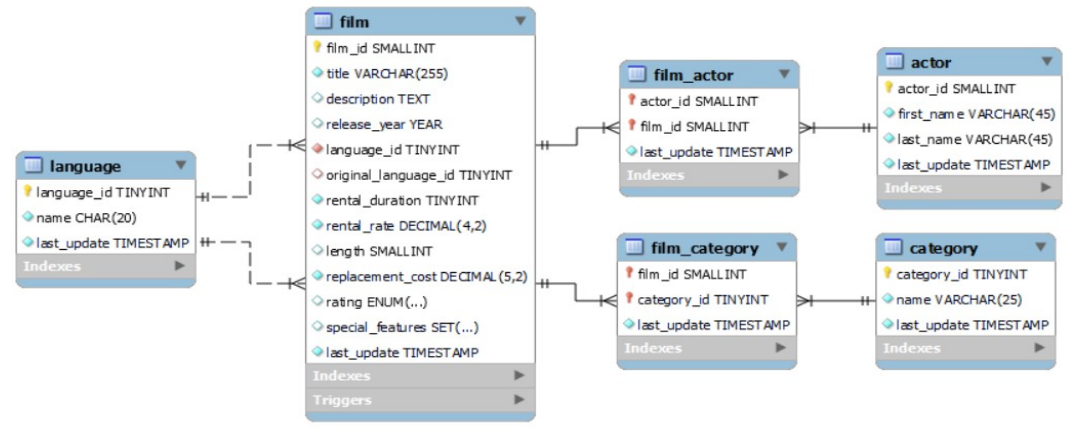

In [1]:
# Vamos começar apenas abrindo a conexão

import mysql.connector
from functools import partial


def get_connection_helper():

    def run_db_query(connection, query, args=None):
        with connection.cursor() as cursor:
            print('Executando query:')
            cursor.execute(query, args)
            for result in cursor:
                print(result)

    connection = mysql.connector.connect(
        host='localhost',
        user='megadados',
        password='megadados',
        database='sakila',
    )
    return connection, partial(run_db_query, connection)


connection, db = get_connection_helper()

Escreva queries SQL para responder as perguntas abaixo:

**a)** Alguns atores são supersticiosos. Um ator supersticioso prefere participar em filmes cujo titulo começa
com a mesma letra de seu primeiro nome. Por exemplo, se um ator chamado “Adam West” é
supersticioso, ele prefere atuar em filmes que começam com a letra “A”.

Quais os 10 atores mais supersticiosos? Considere que o escore de superstição de um ator é a fração de
filmes do ator que começam com a mesma letra do nome dele.
Dica: para extrair a primeira letra de uma string use a função LEFT(str, quantidade) do MySQL. Consulte a
documentação conforme necessário.


In [15]:
# Score = filme que começam com a mesma letra/ total de filmes que ele participou

# 1) Temporary table que vai guardar o total de filmes que tem a mesma letra do ator

db('''DROP TABLE IF EXISTS movies_same_letter''')

db('''
CREATE TEMPORARY TABLE movies_same_letter
    SELECT
        title, actor_id, first_name, COUNT(film_id) as cnt_filme
    FROM
        film
        INNER JOIN film_actor USING (film_id)
        INNER JOIN actor USING (actor_id)
    WHERE
        LEFT(title, 1) = LEFT(first_name, 1)   
    GROUP BY
        actor_id
    ORDER BY
        cnt_filme DESC
''')

#db('SELECT * FROM movies_same_letter')

Executando query:
Executando query:


In [16]:
# 2) Temporary table que vai guardar o total de filmes que o ator participou

db('''DROP TABLE IF EXISTS total_movies''')

db('''
CREATE TEMPORARY TABLE total_movies
    SELECT
        first_name, actor_id, COUNT(film_id) as total_per_actor
    FROM
        film
        INNER JOIN film_actor USING (film_id)
        INNER JOIN actor USING (actor_id)
    GROUP BY
        actor_id
    ORDER BY
        total_per_actor DESC
''')

#db('SELECT * FROM total_movies')

Executando query:
Executando query:


In [20]:
# 3) Fazer inner join das duas tabelas pelo actor_id e fazer a fração
# Score = filme que começam com a mesma letra/ total de filmes que ele participou

db('''
SELECT
    actor_id, total_movies.first_name, cnt_filme/total_per_actor as supersticao
FROM
    total_movies
    INNER JOIN movies_same_letter USING (actor_id)
ORDER BY
    supersticao DESC
LIMIT  
    10
''')


Executando query:
(24, 'CAMERON', Decimal('0.2917'))
(23, 'SANDRA', Decimal('0.2703'))
(100, 'SPENCER', Decimal('0.2500'))
(90, 'SEAN', Decimal('0.1818'))
(89, 'CHARLIZE', Decimal('0.1667'))
(147, 'FAY', Decimal('0.1613'))
(58, 'CHRISTIAN', Decimal('0.1563'))
(124, 'SCARLETT', Decimal('0.1538'))
(72, 'SEAN', Decimal('0.1538'))
(101, 'SUSAN', Decimal('0.1515'))


**b)** Quais os atores que não participaram de nenhum filme com classificação indicativa (rating) “R”?



In [36]:
#1) Temp table: Todos os filmes com classificação indicativa tipo R

#2) OUTER JOIN com atores para pegar aqueles em que a relação é NULL

db('''DROP TABLE IF EXISTS rating_R''')

db('''
CREATE TEMPORARY TABLE rating_R
    SELECT
        actor_id, first_name, last_name, SUM(rating) as total_R_films
    FROM
        film
        INNER JOIN film_actor USING (film_id)
        INNER JOIN actor USING (actor_id)
    WHERE
        rating = 'R'
    GROUP BY
        actor_id
''')

db('SELECT * FROM rating_R')

Executando query:
Executando query:
Executando query:
(55, 'FAY', 'KILMER', 16.0)
(96, 'GENE', 'WILLIS', 24.0)
(110, 'SUSAN', 'DAVIS', 12.0)
(138, 'LUCILLE', 'DEE', 16.0)
(3, 'ED', 'CHASE', 20.0)
(12, 'KARL', 'BERRY', 32.0)
(13, 'UMA', 'WOOD', 32.0)
(82, 'WOODY', 'JOLIE', 32.0)
(100, 'SPENCER', 'DEPP', 32.0)
(160, 'CHRIS', 'DEPP', 12.0)
(167, 'LAURENCE', 'BULLOCK', 24.0)
(187, 'RENEE', 'BALL', 32.0)
(52, 'CARMEN', 'HUNT', 12.0)
(102, 'WALTER', 'TORN', 20.0)
(136, 'ED', 'MANSFIELD', 32.0)
(139, 'EWAN', 'GOODING', 20.0)
(155, 'IAN', 'TANDY', 16.0)
(159, 'LAURA', 'BRODY', 12.0)
(25, 'KEVIN', 'BLOOM', 16.0)
(26, 'RIP', 'CRAWFORD', 28.0)
(105, 'SIDNEY', 'CROWE', 44.0)
(119, 'WARREN', 'JACKMAN', 44.0)
(126, 'FRANCES', 'TOMEI', 24.0)
(1, 'PENELOPE', 'GUINESS', 12.0)
(4, 'JENNIFER', 'DAVIS', 16.0)
(22, 'ELVIS', 'MARX', 8.0)
(150, 'JAYNE', 'NOLTE', 28.0)
(164, 'HUMPHREY', 'WILLIS', 24.0)
(38, 'TOM', 'MCKELLEN', 20.0)
(42, 'TOM', 'MIRANDA', 24.0)
(67, 'JESSICA', 'BAILEY', 28.0)
(157, 'GRETA', 'M

In [43]:
#2) OUTER JOIN com atores para pegar aqueles em que a relação é NULL

# Se não existisse na tabela rating_R, ele preenche a soma com NULL. Quero exatamente isso!

db('''
SELECT
    actor_id, actor.first_name, actor.last_name, total_R_films
FROM
    rating_R
    RIGHT OUTER JOIN actor USING (actor_id)
WHERE
    total_R_films IS NULL
GROUP BY
    actor_id
''')




Executando query:
(131, 'JANE', 'JACKMAN', None)


**c)** Suponha que desejamos adicionar uma coluna na tabela “actor” que contêm a contagem de filmes no
qual o ator participa. Implemente em SQL o mecanismo necessário para manter essa contagem correta
sempre que um filme for adicionado ou removido.


Todas as vezes que for relacionar e adicionar um filme a um ator, na tabela de ator vai atualizar a contagem de filmes do caritchas;

```mysql

USE sakilla;

# Adicionando a coluna para a tabela
ALTER TABLE actor
	ADD COLUMN (
		films_per_actor INT NOT NULL,
 );


# Criando o trigger para aumentar a contagem de filmes do ator

DROP TRIGGER IF EXISTS trig_cnt_filmes_add;

DELIMITER //
CREATE TRIGGER trig_cnt_filmes_add 
BEFORE INSERT ON film_actor
FOR EACH ROW
BEGIN
    UPDATE actor 
        SET films_per_actor = films_per_actor + 1; 
        WHERE actor.id_actor = NEW.id_actor; # NEW.actor_id linhas inseridas no film_actor
END//

DELIMITER ;

# Criando o trigger para diminuir a contagem de filmes do ator

DROP TRIGGER IF EXISTS trig_cnt_filmes_del;

DELIMITER //
CREATE TRIGGER trig_cnt_filmes_del 
BEFORE DELETE ON film_actor
FOR EACH ROW
BEGIN
    UPDATE actor 
        SET films_per_actor = films_per_actor - 1; 
        WHERE actor.id_actor = OLD.id_actor;
END//

DELIMITER ;

```

UPDATE tabela SET NEW---- WHERE OLD------ 

## 2)

O site lichess.org permite que pessoas do mundo todo joguem xadrez online (mesmo com deficiência
visual!). É gratuito, funciona com doações (lichess.org é uma instituição sem fins lucrativos na França) que
servem para sustentar o custo dos servidores (web app, varios bancos de dados, sistemas de análise de jogos
– e.g. stockfish – etc.) e o salário do desenvolvedor principal e criador da plataforma. O código-fonte é
aberto, e desenvolvido principalmente em Scala (pelas vantagens da programação funcional, vejam só!).
Na página de doações (https://lichess.org/patron) tem uma planilha de custos que lista todos os servidores,
suas capacidades e custos. 


Tem também um dado interessante: são **5.200.000** jogos por dia atualmente!
Suponha que cada **jogo tem em média 50 lances**, que cada lance pode ser **armazenado como um par de
bytes** indicando a casa de origem e destino de uma peça. Suponha ainda que **o número de jogos por dia
dobra a cada ano**. A planilha de custos do lichess informa que **o servidor de banco de dados tem 3840 GB** de
disco; suponha que **1TB ainda esteja livre para armazenamento de dados**. A partir de agora, quantos anos de
armazenamento de jogos o servidor ainda aguenta?

Obs: Dobra a cada ano mas vai crescendo proporcionalmente a cada dia.

In [44]:
#jogos/dia * 2 ^dia/ano * lances/jogo * bytes/lance = bytes/ano

In [46]:
jogos = 5_200_000 # Jogos por dia
memoria_livre  = 1 # Memoria livre em Tb
dias = 10000 # Testando alguns dias
memoria_gastada = 0

def f(t):
    return (jogos*2**(t/365)*50*2)/1e12  # no caso Tb
    
for dia in range(0, dias):
    memoria_gastada += f(dia)
    if memoria_gastada >= memoria_livre:
        break
    
print(f"O tempo que ainda aguenta: {dia/365} ano")

O tempo que ainda aguenta: 2.2164383561643834 ano


## 3)

Explique com suas palavras: porque o Spark é baseado em um paradigma de programação funcional?

R : 

Transformação de dados com muitos dados.

O Spark é uma ferramenta de ETL (extract, transform e load).

Nesse caso, informações relevantes são extraídas, essas informações são transformadas e depois são carregadas em um banco de dados. Como se fosse uma pipeline, ou de maneira mais geral, como se fosse um DAG (directed acyclic graph). 

Nesse caso temos uma fonte, vários processos e destinos. Dessa forma, podemos modelar por funções.
- Pode ser bem modelada por chamadas de função e fluxos de dados sem side effects (depende apenas da entrada dele, não mais de outras coisas). Além disso, itens de dados são independentes

E por que é vantajoso adotar o resto o paradigma funcional? Como isso influencia na implementação?

- Pode implementar com funções sem side effect (chamada de função que altera o estado global sendo que a função depende - se chamar 2 vezes, os resultados serão diferentes - não é paralelizável e nem cacheavel). 
- Itens independentes - posso processar em qualquer ordem - são processáveis em paralelo, isto implica que programação funcional é uma boa ideia, pois possui:
        - Paralelismo: uma chamada de funçã não depende de outra, um item processado não afeta outro item.
        - Usar múltiplos processadores separados (diferença entre máquinas multi core e em cluster). No caso temos o cluster- sem compartilhar o estado global.
        - Robustez: se uma unidade de processamento é perdida, podemos apenas recomputar o que foi perdido - ou seja, se o processador cai, recomputa apenas o necessário.
        - Na programação funcional, podemos passar funções e receber funções. O argumento de entrada do 'map' é uma função. Ou seja, funções como objetos de primeira classe.
        

**O RESUMO** : programação funcional implica em : 
    - Sem efeitos colaterais.
    - Sem estado global.
    - Funções como objeto de primeira classe, permitindo enviar código para uma função.
        
E isso facilita paralelismo porque também facilita dados independentese migração de código.

## 4)

Escreva uma função em Python usando apenas ferramentas de programação funcional (como map(),
functools.reduce(), filter(), zip(), list comprehensions, etc.) para a seguinte tarefa:

- São dadas duas listas x e y de números reais, de mesmo comprimento n. Cada elemento de cada lista é um número real ou None, indicando que o número está ausente.
- A função deverá calcular a soma a seguir:

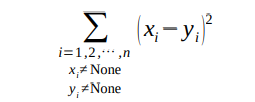

Ou seja, a soma dos quadrados das diferenças entre os valores de x e y, mas apenas quando ambos os valores não são None.

In [93]:
from functools import *

x = [1, None, 6, None, 7, 10, 21]
y = [5, 7, None, 4, 2, None, 13]


# Primeiro podemos fazer um filter para tirar os Nones
# Podemos fazer um map para colocar os dois termos e soma (reduce)

zippado = list(zip(x, y))

zip_filtrado = list(filter((lambda x : x[0] != None and x[1] != None), zippado))

print(zippado)
print(zip_filtrado)

soma_parcial = list(map(lambda x : (x[0]-x[1])**2, zip_filtrado))

soma_final = reduce(lambda x, y: x + y, soma_parcial)

print(f"Resultado da soma {soma_parcial}")
print(f"Resultado final {soma_final}")

[(1, 5), (None, 7), (6, None), (None, 4), (7, 2), (10, None), (21, 13)]
[(1, 5), (7, 2), (21, 13)]
Resultado da soma [16, 25, 64]
Resultado final 105


In [91]:
somatorio = sum([(a - b)**2 for a, b in zip_filtrado])
somatorio

105

In [92]:
# Exemplo de list comprehension:

fruits = ["apple", "banana", "cherry", "kiwi", "mango"]

newlist = [x for x in fruits if "a" in x]

print(newlist)

['apple', 'banana', 'mango']


## 5)

Construa um par de transações que geram resultados diferentes se usamos o modo de serialização
SERIALIZABLE, REPEATABLE READ e READ COMMITTED.

T1

``` mysql
SELECT COUNT (*) INTO @cnt FROM tabela 1
UPDATE tabela2 SET x = x + @cnt WHERE id = 1
SELECT  COUNT(*) INTO @cnt FROM TABELA 1
UPDATE tabela2 SET x = x - @cnt WHERE id = 1
COMMIT
```
T2

``` mysql
INSERT INTO tabela1 VALUES(...) ;
SELECT x INTO @x FROM tabela2 WHERE id=1
SELECT x INTO @Y FROM tabela2 WHERE id=1
UPDATE tabela2 SET x = x - @Y WHERE id = 
COMMIT

```




- Serializable: vai ter que terminar a transação 1 inteira para depois rodar a 2.
- Repeatable Read : a leitura não muda, mas no final os valores não seram esperados, ou seja, iguais ao original - pois pode ser que uma linha tenha sido inserida e commitada em T2. 
- Read commited = T2 você vai rodar 1, 2 aí vai para T1 e roda tudo e volta pra T2 e roda o que restou. Valor vai ser diferente, pois vai ler o commitado, não vai ficar lendo o mesmo.

## 6)

Em uma relação R(A, B, C, D) valem as seguintes dependências funcionais não-triviais: AB→C, C→ D,D→ A. Determine:

e) A chave primária.

d) A forma normal da relação

f) Uma normalização para a BCNF.

e)  

Chaves candidatas: AB, BD, BC

Vamos escolher AB.

d) 
- Colunas com valor simples OK 1NF 
- Não há dependência parcial OK 2NF
- Não há dependência transitiva NÃO 

Portanto está em 2NF

f) 

AB→C, C→ D,D→ A

BCNF - determinante faz parte da chave primária, mas quem tá sendo determinado não 

R(A,B,C) : Chave primária AB [AB → C]

S (C, D) : Chave primária C [C → D]

T(D, A) : Chave primária D. [D → A]